In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Scaffolds import MurckoScaffold
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
import math
import numpy as np
from rdkit import DataStructs as ds
from matplotlib import offsetbox
from sklearn import manifold
from scipy.spatial import distance
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

from rdkit.Chem.SaltRemover import SaltRemover

# funkce

In [2]:
soubor = "../Projekt/Data/GlucocorticoidReceptor.txt"
def ReadAllData(_soubor):
    newData = []
    counter = 0
    with open(_soubor, "r") as f:
        next (f)
        for line in f:
            radek = line.strip().split("\t")
            radek = (Chem.MolFromSmiles(radek[10]),float(radek[14]))
            newData.append(radek)
    return newData

def ReadAllDataNE(_soubor):
    newData = []
    counter = 0
    with open(_soubor, "r") as f:
        next (f)
        for line in f:
            radek = line.strip().split("\t")
            try:
                radek = (Chem.MolFromSmiles(radek[10]),float(radek[14]))
                newData.append(radek)                    
            except ValueError:
                counter += 1
    print("prazdne: " + str(counter))
    return newData

def ReadNoActiveData(_soubor):
    newData = []
    counter=0
    with open(_soubor, "r") as f:
        next (f)
        for line in f:
            radek = line.strip().split("\t")
            try:
                if float(radek[14]) > 5000:
                    radek = (radek[0],Chem.MolFromSmiles(radek[10]),float(radek[14]))
                    newData.append(radek)
            except ValueError:
                counter += 1
    print("prazdne: " + str(counter))
    return newData

# nacteni dat

In [3]:
# pocet neaktivnich ligandu, > 5000
noValMols = ReadNoActiveData(soubor)
print("pocet neaktivnich molekul", len(noValMols))

prazdne: 981
pocet neaktivnich molekul 205


In [4]:
#mols = ReadAllData(soubor)
activeMols = ReadAllDataNE(soubor)

prazdne: 981


In [5]:
pvals = ([-math.log10(val[1]) for val in activeMols])

# scaffoldy

In [6]:
def make_atomic_scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol)
    atomic_scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    try:
        Chem.SanitizeMol(atomic_scaffold)
    except ValueError:
        return None
    return atomic_scaffold

def make_graph_scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol)
    atomic_scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    try:
        Chem.SanitizeMol(atomic_scaffold)
        graph_scaffold = MurckoScaffold.MakeScaffoldGeneric(atomic_scaffold)
    except ValueError:
        return None
    return graph_scaffold


In [7]:
all_atomic_scaffolds = [make_atomic_scaffold(mol[0]) for mol in activeMols]
len(all_atomic_scaffolds), len([x for x in all_atomic_scaffolds if x])

all_graph_scaffolds = [make_graph_scaffold(mol[0]) for mol in activeMols]
len(all_graph_scaffolds), len([x for x in all_graph_scaffolds if x])

(2768, 2768)

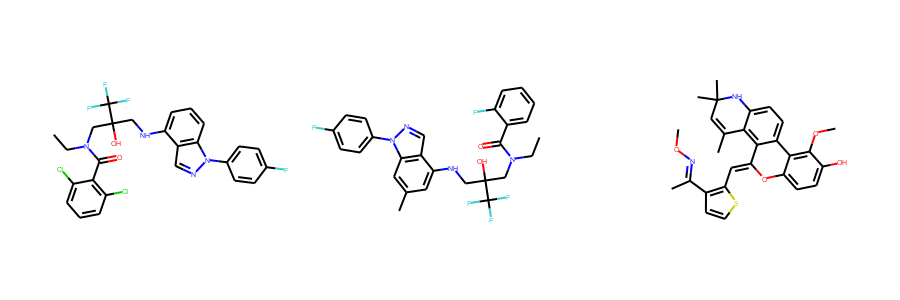

In [8]:
Draw.MolsToGridImage([x[0] for x in activeMols[:3]],subImgSize=(300, 300))

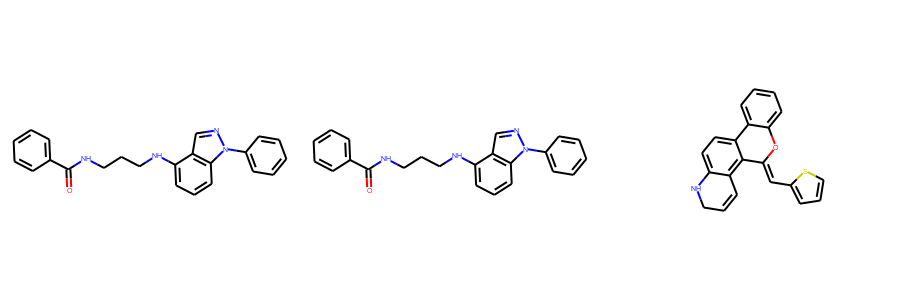

In [9]:
Draw.MolsToGridImage(all_atomic_scaffolds[:3], subImgSize=(300, 300))

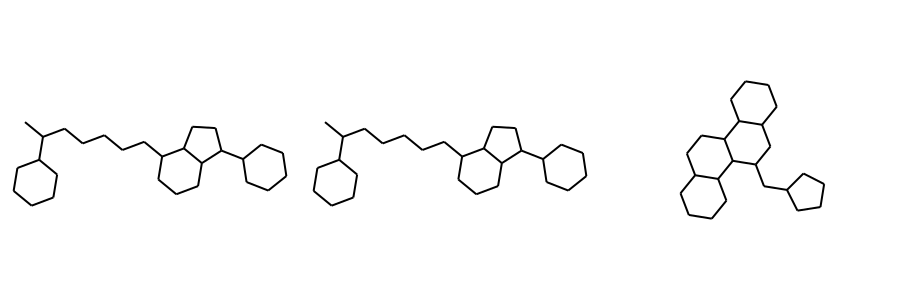

In [10]:
Draw.MolsToGridImage(all_graph_scaffolds[:3], subImgSize=(300, 300))

# ________________________

# fingerprinty

In [11]:

activeFps = [Chem.GetMorganFingerprintAsBitVect(m[0],2,nBits=1024) for m in activeMols]
fps = [Chem.GetMorganFingerprintAsBitVect(m[1],2,nBits=1024) for m in noValMols]

In [12]:
sparse_mat = distance.pdist(activeFps,metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

In [13]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

In [14]:
def plot_embedding(X, title=None, highlights=[], highlights2=[]):
    fig = plt.figure()
    for i, point in enumerate(X):
        x,y = point
        if i in highlights:
            plt.plot([x],[y],"r.", markersize=8)
        elif i in highlights2:
            plt.plot([x],[y],"b.", markersize=8)
        else:
            plt.plot([x],[y],"k.", markersize=1)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    #return fig

# exploration

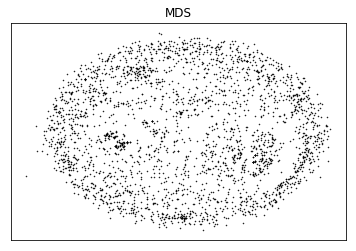

In [15]:
plot_embedding(X_mds,"MDS")

In [16]:
#ligand s nejlepsi aktivitou

In [17]:
sortedMols = sorted(activeMols, key=lambda stdVal: stdVal[1])

In [18]:
bestActivity = sortedMols[0][0]

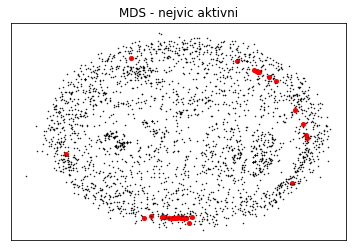

In [19]:
ba_idxs = [i for i,m in enumerate([x[0] for x in activeMols]) if m.HasSubstructMatch(bestActivity)]
plot_embedding(X_mds,"MDS - nejvic aktivni",highlights=ba_idxs)

38

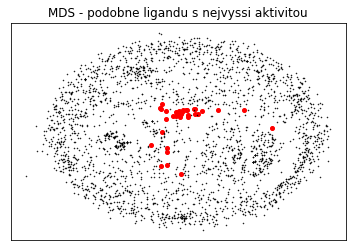

In [20]:
ba_like_structs_idxs = [i for i, dist in enumerate(dist_mat[0,]) if dist<0.5] 
plot_embedding(X_mds,"MDS - podobne ligandu s nejvyssi aktivitou",highlights=ba_like_structs_idxs)
len(ba_like_structs_idxs )

In [21]:
ba_like_structs = [m for m in [x[0] for x in activeMols] if m.HasSubstructMatch(bestActivity)]

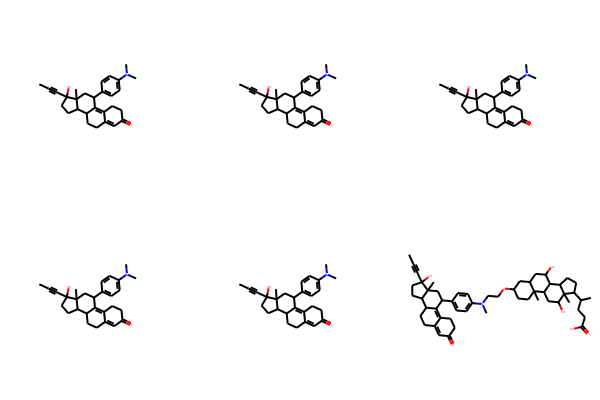

In [22]:
Draw.MolsToGridImage(ba_like_structs[:6])

In [23]:
def full_distance_function(index1, index2, *args, matrix=dist_mat):
    return dist_mat[index1,index2]

picker = MaxMinPicker()
picked = picker.LazyPick(full_distance_function, len(activeMols), 100, seed=666)
highlighted = tuple(picked)
#len(picked)

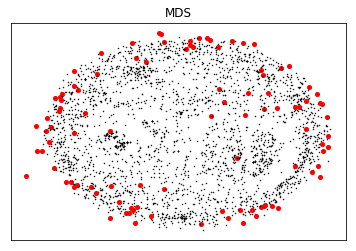

In [24]:
plot_embedding(X_mds,"MDS",highlights=highlighted)

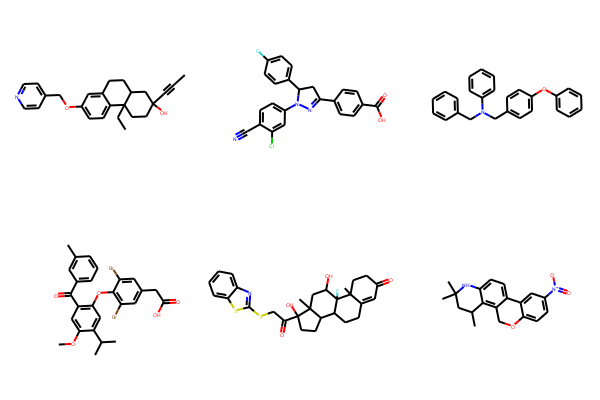

In [25]:
Draw.MolsToGridImage([[x[0] for x in activeMols][i] for i in highlighted[94:]])

# ____________________________________________

In [26]:
hasCarbonPatt = Chem.MolFromSmarts("[#6]")
onlyOrganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]")
onlyOrganics = [(i, m.HasSubstructMatch(hasCarbonPatt) and not m.HasSubstructMatch(onlyOrganicPatt)) for i,m in enumerate([x[0] for x in activeMols])]
onlyOrganicIdxs = [i for i,hasPatt in onlyOrganics if hasPatt]
notOnlyOrganicIdxs = [i for i,hasPatt in onlyOrganics if not hasPatt]
len(notOnlyOrganicIdxs)

7

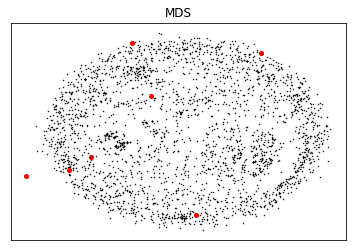

In [27]:
plot_embedding(X_mds,"MDS",highlights=notOnlyOrganicIdxs)

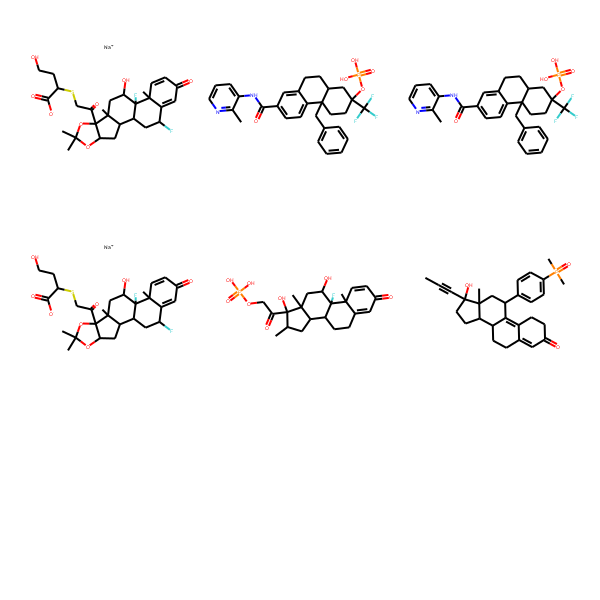

In [28]:
Draw.MolsToGridImage([[x[0] for x in activeMols][i] for i in notOnlyOrganicIdxs])

In [29]:
remover = SaltRemover(defnData='[!C;!c;!#7;!#8;!#16;!Cl;!F;!Br;!I]')
remover2 = SaltRemover()

In [30]:
print([Chem.MolToSmarts(mol) for mol in remover.salts])
print([Chem.MolToSmarts(mol) for mol in remover2.salts])

['[!C&!c&!#7&!#8&!#16&!Cl&!F&!Br&!I]']
['[Cl,Br,I]', '[#3,#11,#19,#20,#12]', '[O,N]', 'N(=O)(-,:O)-,:O', 'P(=O)(-,:O)(-,:O)-,:O', 'P(-,:F)(-,:F)(-,:F)(-,:F)(-,:F)-,:F', 'S(=O)(=O)(-,:O)-,:O', '[C&H3]-,:S(=O)(=O)-,:O', 'c1:,-c:,-c(-,:[C&H3]):,-c:,-c:,-c:,-1-,:S(=O)(=O)-,:O', '[C&H3]-,:C(=O)-,:O', 'F-,:C(-,:F)(-,:F)-,:C(=O)-,:O', 'O-,:C(=O)-,:C=C-,:C(=O)-,:O', 'O-,:C(=O)-,:C(=O)-,:O', 'O-,:C(=O)-,:C(-,:O)-,:C(-,:O)-,:C(=O)-,:O', 'C1-,:C-,:C-,:C-,:C-,:C-,:1-,:[N&H1]-,:C1-,:C-,:C-,:C-,:C-,:C-,:1']


In [31]:
activeMols = [x[0] for x in activeMols]

In [32]:
print(Chem.MolToSmiles(activeMols[notOnlyOrganicIdxs[5]]))
print(Chem.MolToSmiles(remover2(activeMols[notOnlyOrganicIdxs[5]])))

CC#CC1(O)CCC2C3CCC4=CC(=O)CCC4=C3C(c3ccc(P(C)(C)=O)cc3)CC21C
CC#CC1(O)CCC2C3CCC4=CC(=O)CCC4=C3C(c3ccc(P(C)(C)=O)cc3)CC21C


In [33]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol

In [34]:
print(Chem.MolToSmiles(remover2(activeMols[notOnlyOrganicIdxs[5]])))
print(Chem.MolToSmiles(NeutraliseCharges(remover2(activeMols[notOnlyOrganicIdxs[5]]))))

CC#CC1(O)CCC2C3CCC4=CC(=O)CCC4=C3C(c3ccc(P(C)(C)=O)cc3)CC21C
CC#CC1(O)CCC2C3CCC4=CC(=O)CCC4=C3C(c3ccc(P(C)(C)=O)cc3)CC21C


In [35]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]")
_carbonPatt = Chem.MolFromSmarts("[#6]")
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [36]:
#cleanMols = [sm for sm in (standardize(m) for m in activeMols if m) if sm]

counter = -1
cleanMols = []
poleOdstranenych = []

for mol in activeMols:
    counter += 1    
    if standardize(mol):
        cleanMols.append(standardize(mol))
    else:
        poleOdstranenych.append(counter)
for i in range(len(poleOdstranenych)):
 pvals.pop(poleOdstranenych[i])

cleanFps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=1024) for i,m in enumerate(cleanMols)]

In [37]:
clean_sparse_mat = distance.pdist(cleanFps,metric="jaccard")
clean_dist_mat = distance.squareform(clean_sparse_mat)

#Calculate new 2D coordinates with MDS

#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
clean_mds = clf.fit_transform(clean_dist_mat)

In [38]:
def clean_distance_function(index1, index2, *args, matrix=clean_dist_mat):
    return matrix[index1,index2]

picker = MaxMinPicker()
clean_picked = picker.LazyPick(clean_distance_function, len(cleanFps), 100, seed=666)
clean_highlighted = tuple(clean_picked)

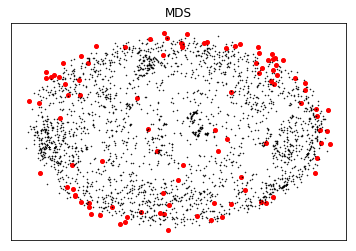

In [39]:
plot_embedding(clean_mds,"MDS",highlights=clean_highlighted)

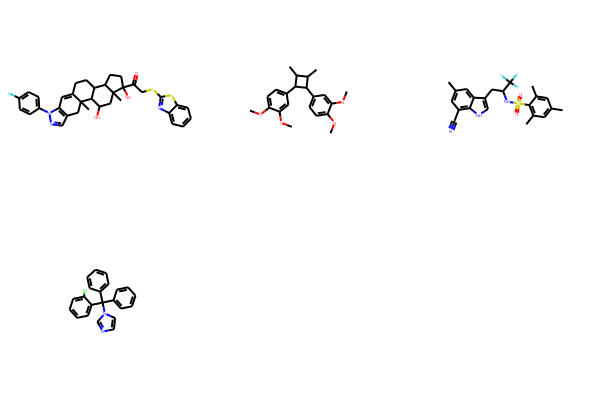

In [40]:
Draw.MolsToGridImage([cleanMols[i] for i in clean_picked[:4]])

In [41]:
from sklearn.preprocessing import StandardScaler
fpsStd = StandardScaler().fit_transform(activeFps)
cleanActiveFpsStd = StandardScaler().fit_transform(cleanFps)

In [42]:
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(fpsStd)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2'])

In [43]:
aprincipalComponents = pca.fit_transform(cleanActiveFpsStd)
aprincipalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2'])

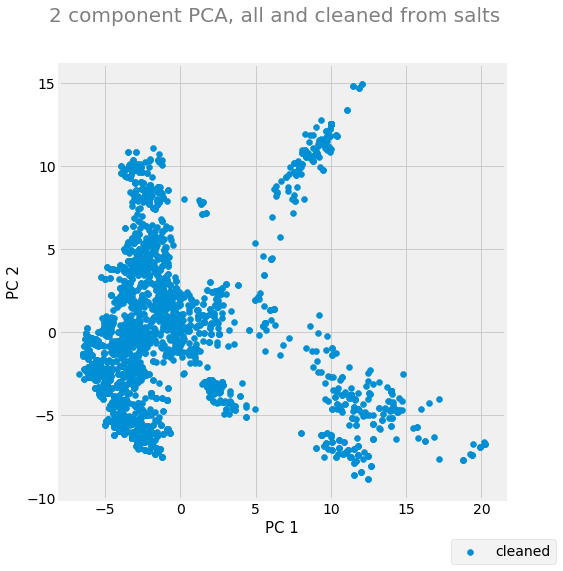

In [44]:
fig = plt.figure(figsize = (8,8))
plt.style.use('fivethirtyeight')
fig.add_subplot(111)
fig.suptitle('2 component PCA, all and cleaned from salts', fontsize = 20, alpha = 0.5)
plt.scatter(aprincipalComponents[:,0], aprincipalComponents[:,1], label='cleaned')
plt.xlabel('PC 1', fontsize = 15)
plt.ylabel('PC 2', fontsize = 15)
fig.legend(loc=4)


In [45]:
#sorted, clean, active
activeMols = ReadAllDataNE(soubor)
activeMols[1]
sortedAmols = sorted(activeMols, key=lambda stdVal: stdVal[1])
sortedpVals = sorted(pvals)
sortedAmols = [x[0] for x in sortedAmols]
sortedACmols=  [sm for sm in (standardize(m) for m in sortedAmols if m) if sm]

prazdne: 981


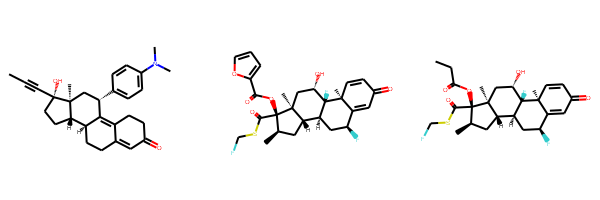

In [46]:
#kontrola jestli jsou porad srovnane podle aktivity
sortedAmols[:5], sortedACmols[:5]
Draw.MolsToGridImage(sortedACmols[:3])

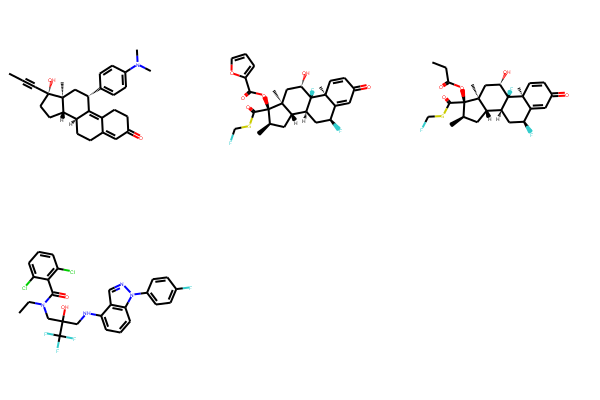

In [47]:
 Draw.MolsToGridImage(sortedAmols[:4])

In [48]:
# porovnani aktivity podle podobnosti vuci nejvice aktivnim ligandum

In [49]:
maccsFps = [MACCSkeys.GenMACCSKeys(mol) for mol in sortedACmols]

In [50]:
taniComparation = []
for i in range(len(maccsFps)):
    taniComparation.append(ds.FingerprintSimilarity(maccsFps[4],maccsFps[i], metric=ds.TanimotoSimilarity))

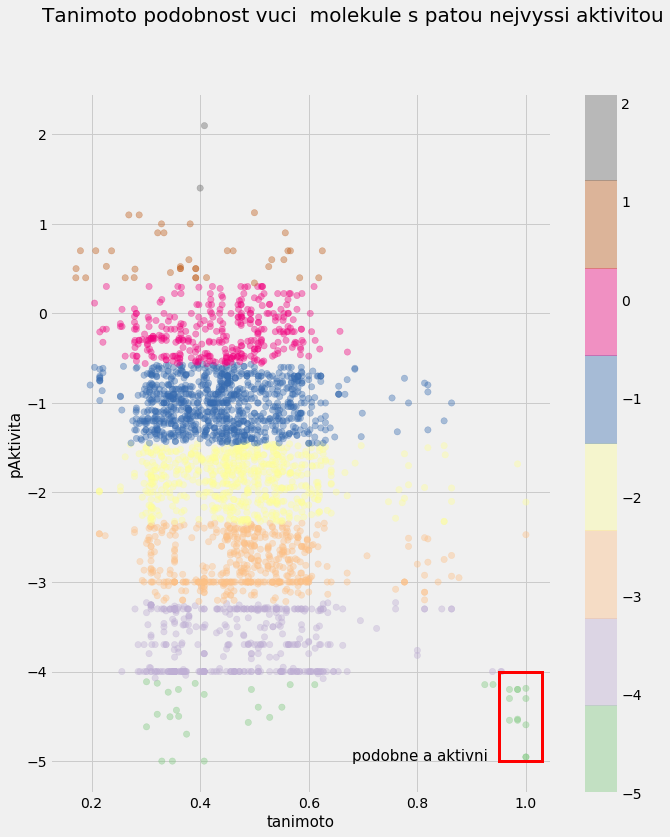

In [51]:
fig = plt.figure(figsize = (10,12))

fig.suptitle('Tanimoto podobnost vuci  molekule s patou nejvyssi aktivitou', fontsize = 20)
plt.style.use('fivethirtyeight')
plt.scatter(taniComparation,sortedpVals, c=sortedpVals, cmap=plt.cm.get_cmap('Accent'), s =40, alpha=0.4)
circle = plt.Rectangle((0.95, -5), .08, 1, color='r', fill=False, linewidth=3)
plt.text(0.68, -5, r'podobne a aktivni', fontsize=15)

plt.gcf().gca().add_artist(circle)
plt.xlabel('tanimoto', fontsize = 15)
plt.ylabel('pAktivita', fontsize = 15)
plt.colorbar()

In [ ]:
# je tam i jedna mene aktivni a pritom hodne podobna

In [52]:
sortedCAFps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=1024) for i,m in enumerate(sortedACmols)]

In [53]:
len(sortedCAFps)

2763

In [54]:
ac_sparse_mat = distance.pdist(sortedCAFps,metric="jaccard")
ac_dist_mat = distance.squareform(ac_sparse_mat)

#Calculate new 2D coordinates with MDS

#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
ac_mds = clf.fit_transform(ac_dist_mat)

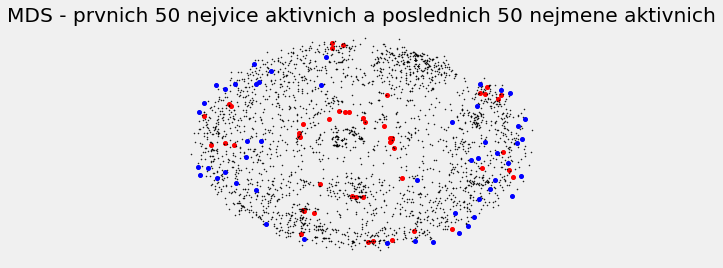

In [55]:
plot_embedding(ac_mds,"MDS - prvnich 50 nejvice aktivnich a poslednich 50 nejmene aktivnich",highlights=list(range(50)),highlights2=list(range(len(sortedCAFps) - 50, len(sortedCAFps))))

In [56]:
sortedCAFpsStd = StandardScaler().fit_transform(cleanFps)

In [57]:
principalComponentsSCA = pca.fit_transform(sortedCAFpsStd)
principalDfSCA = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2'])

In [58]:
# neaktivnich molekul (> 1000) je 1021

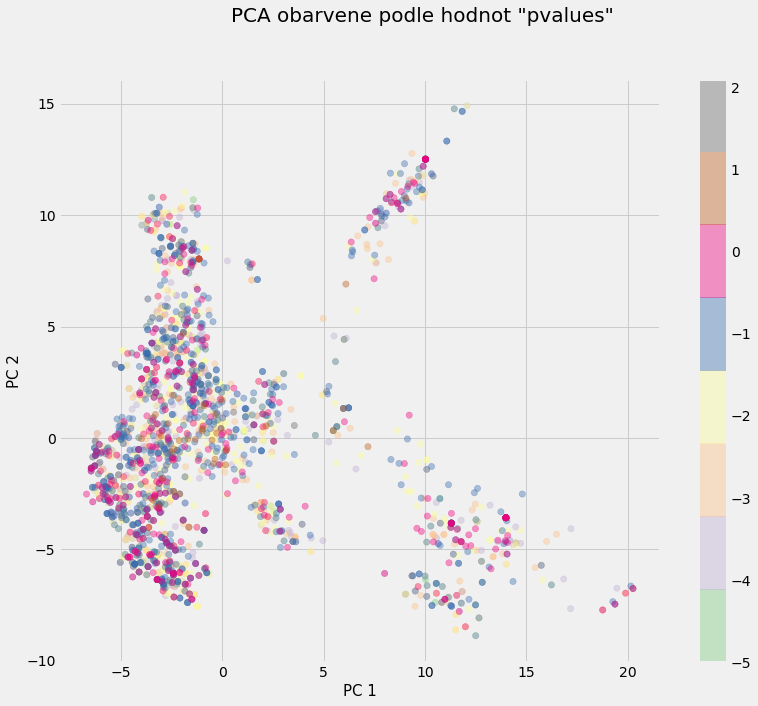

In [74]:
fig = plt.figure(figsize = (12,10))
fig.suptitle('PCA obarvene podle hodnot "pvalues"', fontsize = 20)
plt.style.use('fivethirtyeight')
plt.scatter(principalComponentsSCA[:,0], principalComponentsSCA[:,1], 
            label='all', c=sortedpVals, cmap=plt.cm.get_cmap('Accent'), s =40, alpha=0.4)
plt.xlabel('PC 1', fontsize = 15)
plt.ylabel('PC 2', fontsize = 15)
plt.colorbar()

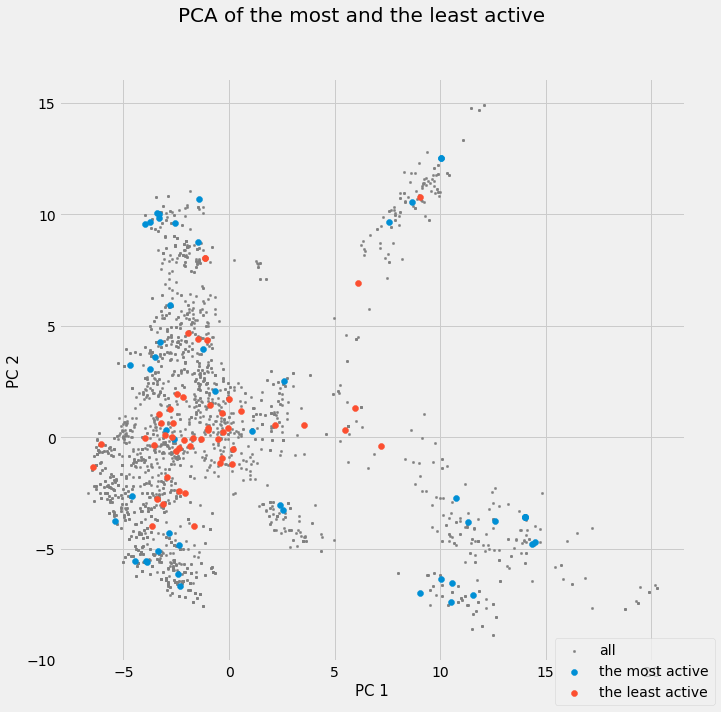

In [60]:
fig = plt.figure(figsize = (10,10))
start = len(sortedCAFps) - 50
end = len(sortedCAFps)

fig.suptitle('PCA of the most and the least active', fontsize = 20)
plt.style.use('fivethirtyeight')
plt.scatter(principalComponentsSCA[:,0], principalComponentsSCA[:,1], label='all', color="grey", s = 5)
plt.scatter(principalComponentsSCA[:50,0], principalComponentsSCA[:50,1], label='the most active')
plt.scatter(principalComponentsSCA[start:end,0], principalComponentsSCA[start:end,1], label='the least active')
plt.xlabel('PC 1', fontsize = 15)
plt.ylabel('PC 2', fontsize = 15)
fig.legend(loc=4)

In [61]:
# PCA zachovava poradi radku
# rekneme, ze vpravo dole je klastr, co je to za ligandy?

In [62]:
indices = []
for i in range(50):
    if principalComponentsSCA[i][0] > 9:
        indices.append(i)
indices
    

[4, 5, 7, 8, 14, 17, 21, 22, 26, 27, 30, 32, 42, 44, 46, 48, 49]

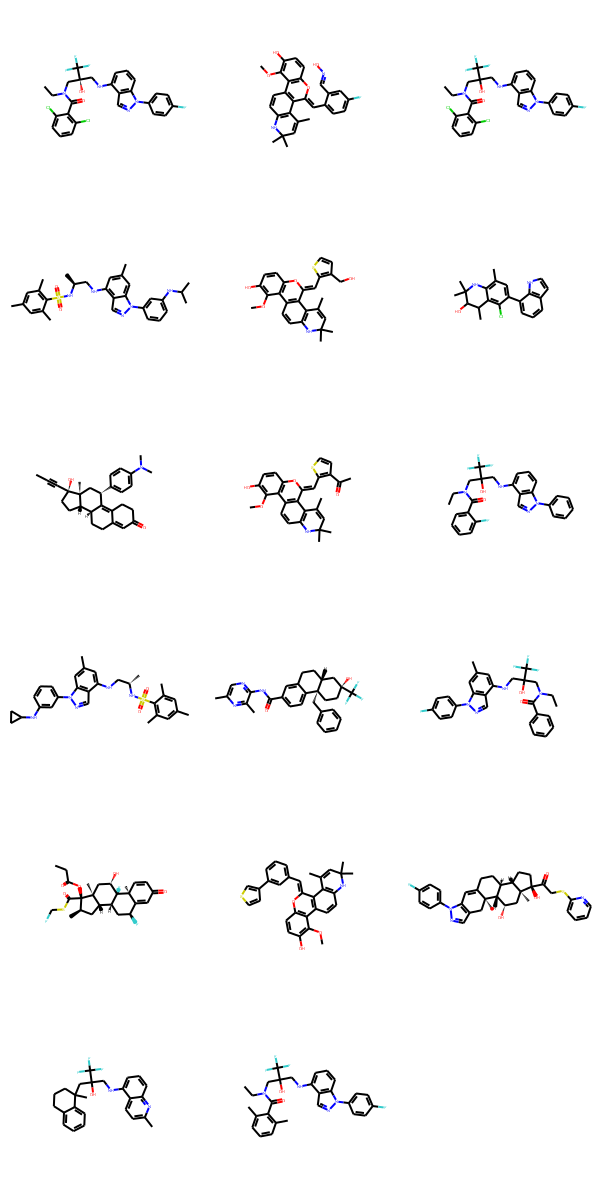

In [63]:
Draw.MolsToGridImage([sortedACmols[i] for i in indices])

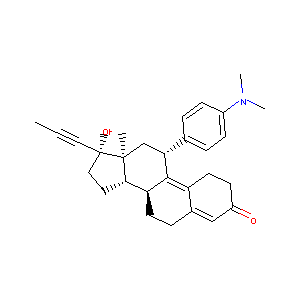

In [64]:
# nejvice aktivni ligand
Draw.MolToImage(sortedACmols[0])

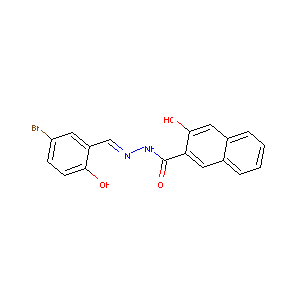

In [65]:
# nejmene aktivni
Draw.MolToImage(sortedACmols[-1])

In [66]:
# pak je tam jeste jeden mini klastr dole uprostred, jsou v nem jen asi 2 z aktivnich
indices2 = []
for i in range(50):
    if principalComponentsSCA[i][0] > 0 and principalComponentsSCA[i][0] < 5 and principalComponentsSCA[i][1] < 0 :
        indices2.append(i)
indices2
    

[15, 31]

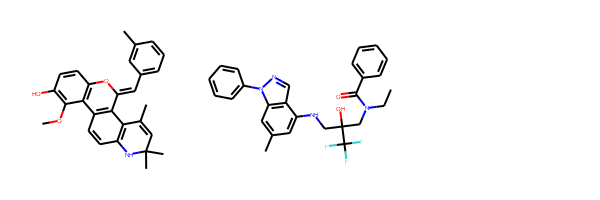

In [67]:
Draw.MolsToGridImage([sortedACmols[i] for i in indices2])

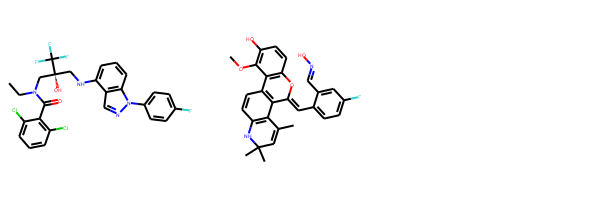

In [68]:
# jeste jednou pro srovnani prvni dve nejvice aktivni z celeho seznamu
Draw.MolsToGridImage([sortedACmols[i] for i in indices[:2]])

In [69]:
# cim se lisi neaktivni od aktivni, vybezek vpravo nahore na grafu

In [70]:
indices3 = []
for i in range(50):
    if principalComponentsSCA[i][0] > 5 and principalComponentsSCA[i][0] < 11 and principalComponentsSCA[i][1] > 5 :
        indices3.append(i)
indices3

[7, 9, 22, 43]

In [71]:
indices4 = []
for i in range(start,end):
    if principalComponentsSCA[i][0] > 5 and principalComponentsSCA[i][0] < 11 and principalComponentsSCA[i][1] > 8 :
        indices4.append(i)
indices4

[2726]

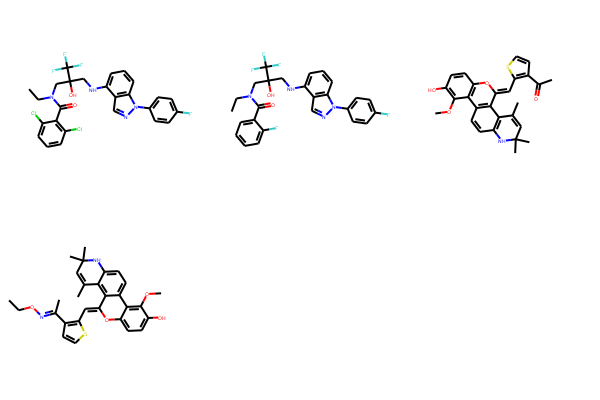

In [72]:
Draw.MolsToGridImage([sortedACmols[i] for i in indices3])

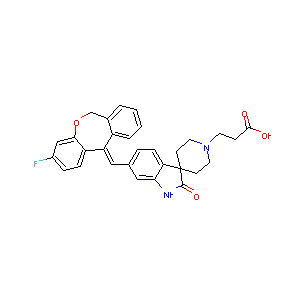

In [73]:
Draw.MolToImage(sortedACmols[2726])

In [ ]:
# bylo by dobre zkusit ruzne dalsi deskriptory, clustery mozna 